In [26]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
import pandas as pd
import shutil
from transformers import CLIPProcessor, CLIPModel
import torch
from tqdm import tqdm 

In [27]:
path_to_image = '/kaggle/input/smoke-fire-detection-yolo/data/test/images'
label_path = '/kaggle/input/smoke-fire-detection-yolo/data/test/labels'

In [28]:
image_files = [f for f in os.listdir(path_to_image)]
text_files = [f for f in os.listdir(label_path) if f.endswith('.txt')]

In [29]:
random.shuffle(image_files)

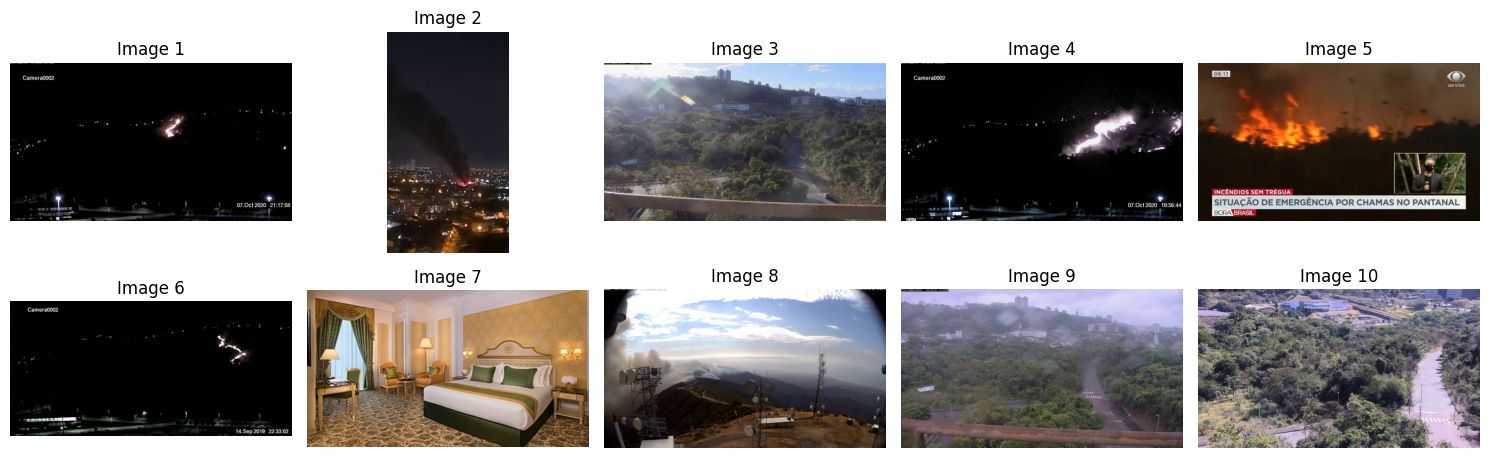

In [30]:
plt.figure(figsize=(15, 5))
for i in range(10):
    img_path = os.path.join(path_to_image, image_files[i])
    img = Image.open(img_path)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Image {i+1}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [31]:
train_path = '/kaggle/input/smoke-fire-detection-yolo/data/train/images'
val_path = '/kaggle/input/smoke-fire-detection-yolo/data/val/images'
test_path = '/kaggle/input/smoke-fire-detection-yolo/data/test/images'
combined_path = '/kaggle/working/all_image'

os.makedirs(combined_path, exist_ok=True)

def move_images(source_folder, dest_folder):
    for filename in os.listdir(source_folder):
        source_file = os.path.join(source_folder, filename)
        dest_file = os.path.join(dest_folder, filename)
        if os.path.isfile(source_file):

            if os.path.exists(dest_file):
                base, ext = os.path.splitext(filename)
                count = 1
                while os.path.exists(dest_file):
                    dest_file = os.path.join(dest_folder, f"{base}_{count}{ext}")
                    count += 1
            shutil.copy2(source_file, dest_file)  

move_images(train_path, combined_path)
move_images(val_path, combined_path)
move_images(test_path, combined_path)

print(f"All images merged into: {combined_path}")


All images merged into: /kaggle/working/all_image


In [32]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model.eval()

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [33]:
batch_size = 64
image_dir = '/kaggle/working/all_image'
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('jpg', 'jpeg', 'png'))]

In [37]:
def classify_batch(images):
    inputs = processor(
        text=["an aerial drone view looking down at forests, mountains, or rural landscapes, where the ground and trees are visible but individual people and vehicles are small or absent", "an image that is NOT an aerial drone view, including ground-level perspectives, urban environments, buildings, indoor scenes, car monitor displays, or unclear views"],
        images=images,
        return_tensors="pt",
        padding=True
    )
    with torch.no_grad():
        outputs = model(**inputs)
        probs = outputs.logits_per_image.softmax(dim=1)
    return probs[:, 0]  

In [38]:
aerial_images = []
ground_images = []

In [39]:
for i in tqdm(range(0, len(image_files), batch_size)):
    batch_files = image_files[i:i+batch_size]
    batch_images = [Image.open(os.path.join(image_dir, f)).convert("RGB") for f in batch_files]

    # Get probabilities
    aerial_probs = classify_batch(batch_images)

    for img_file, prob in zip(batch_files, aerial_probs):
        confidence = prob.item()
        if confidence > 0.5:
            aerial_images.append((img_file, confidence))
        else:
            ground_images.append((img_file, confidence))

print(f"\nTotal Aerial Views: {len(aerial_images)}")
print(f"Total Ground Views: {len(ground_images)}")

100%|██████████| 673/673 [1:30:59<00:00,  8.11s/it]


Total Aerial Views: 12146
Total Ground Views: 30908


In [40]:
df_aerial = pd.DataFrame(aerial_images, columns=['filename', 'confidence'])

df_aerial.to_csv('aerial_images.csv', index=False)


In [42]:
df_aerial.head()

filename  confidence
0              AoF06817.jpg    0.556880
1            AoF06710_1.jpg    0.762991
2            AoF00482_1.jpg    0.683816
3              AoF03651.jpg    0.932642
4  PublicDataset00734_1.jpg    0.686322

In [112]:
new_df= df_aerial[df_aerial['confidence'] > 0.75]

In [113]:
print(new_df)

             filename  confidence
1      AoF06710_1.jpg    0.762991
3        AoF03651.jpg    0.932642
5        WEB06494.jpg    0.787923
6      AoF05318_1.jpg    0.753860
7        AoF00295.jpg    0.956332
...               ...         ...
12136    AoF00258.jpg    0.961667
12141  WEB00900_1.jpg    0.973735
12142  WEB02490_1.jpg    0.974645
12144    AoF02138.jpg    0.879407
12145    AoF05667.jpg    0.977019

[5886 rows x 2 columns]


In [114]:
image_dir = '/kaggle/working/all_image'

In [115]:
shuffled_df = new_df.sample(frac=1).reset_index(drop=True)

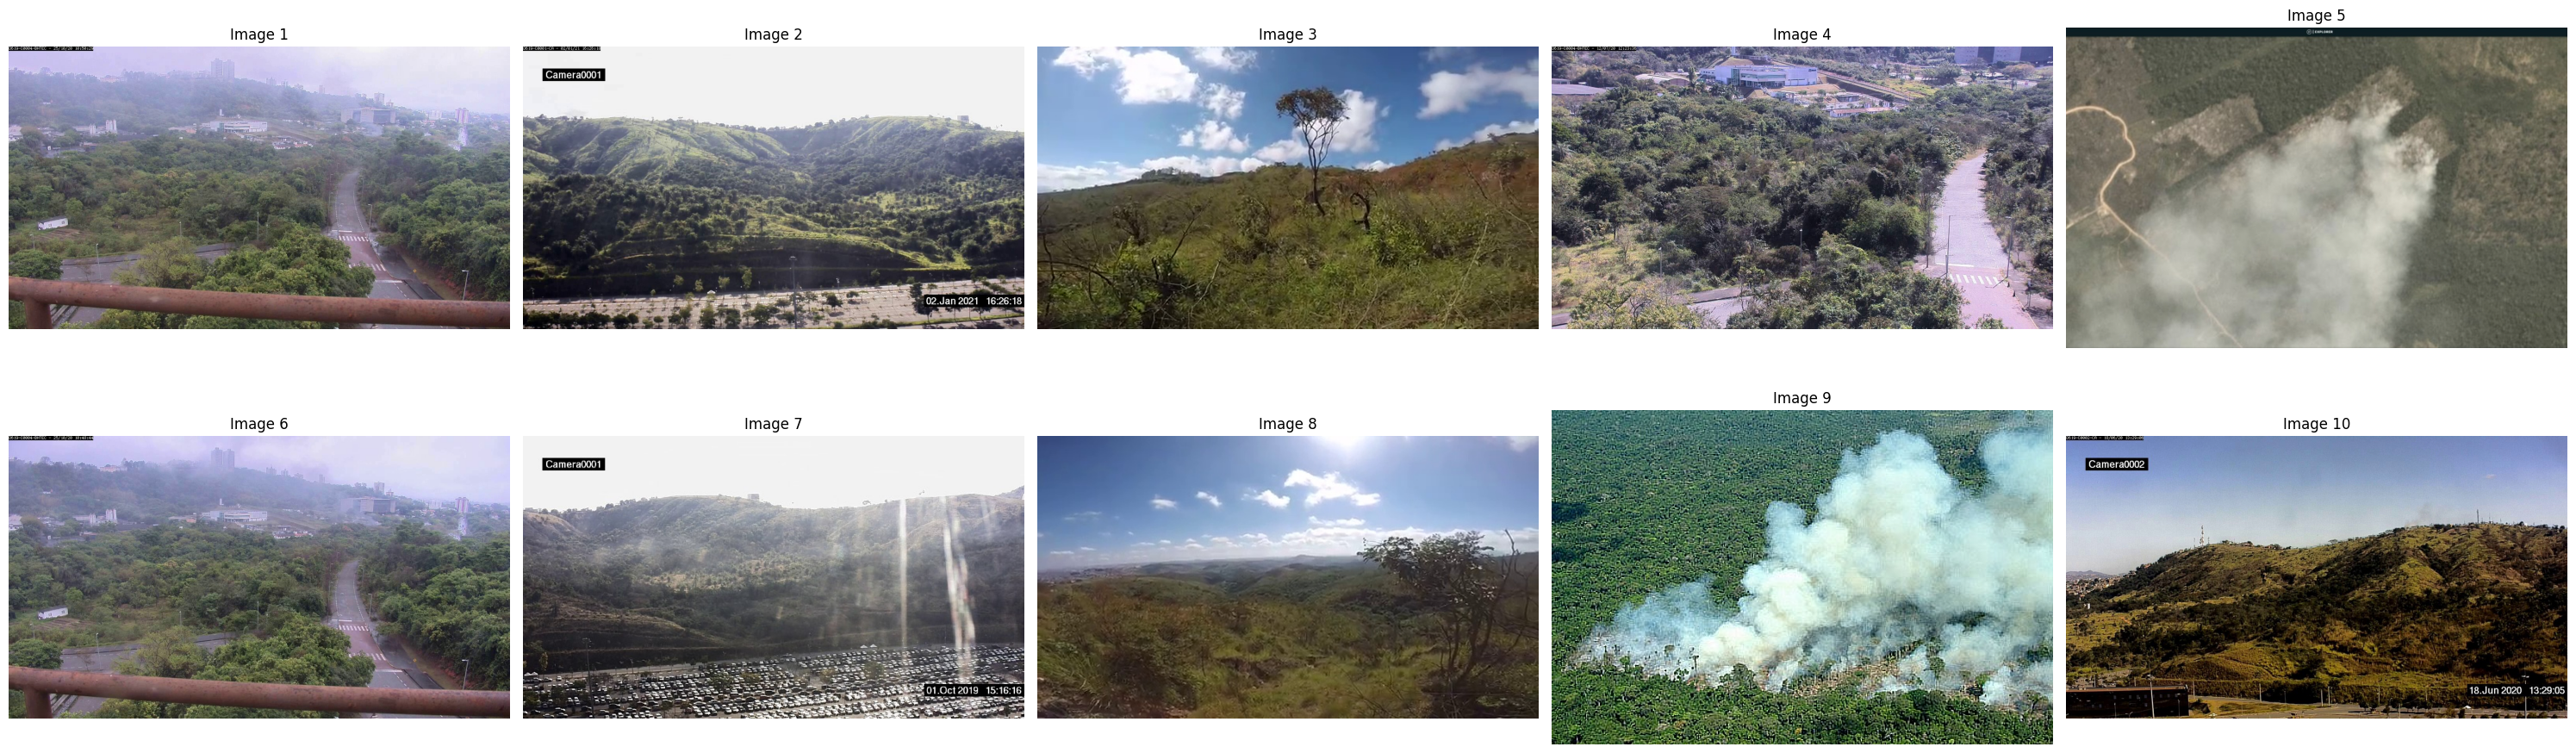

In [116]:
plt.figure(figsize=(30, 10))
for i in range(10):
    img_path = os.path.join(image_dir, shuffled_df.iloc[i]['filename'])
    img = Image.open(img_path)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Image {i+1}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [117]:
combined_path = '/kaggle/working/aerial_images_smoke_fire'

In [120]:
os.makedirs(combined_path, exist_ok=True)
def move_images_csv(source_folder, dest_folder, df):
    for filename in df['filename']:
        source_file = os.path.join(source_folder, filename)
        dest_file = os.path.join(dest_folder, filename)
        if os.path.isfile(source_file):

            if os.path.exists(dest_file):
                base, ext = os.path.splitext(filename)
                count = 1
                while os.path.exists(dest_file):
                    dest_file = os.path.join(dest_folder, f"{base}_{count}{ext}")
                    count += 1
            shutil.copy2(source_file, dest_file)

In [121]:
move_images_csv('/kaggle/working/all_image', combined_path, new_df)

In [128]:
!zip -r /kaggle/working/aerial_images_smoke_fire.zip /kaggle/working/aerial_images_smoke_fire


  adding: kaggle/working/aerial_images_smoke_fire/ (stored 0%)
  adding: kaggle/working/aerial_images_smoke_fire/AoF06710_1.jpg (deflated 1%)
  adding: kaggle/working/aerial_images_smoke_fire/AoF03651.jpg (deflated 0%)
  adding: kaggle/working/aerial_images_smoke_fire/WEB06494.jpg (deflated 8%)
  adding: kaggle/working/aerial_images_smoke_fire/AoF05318_1.jpg (deflated 1%)
  adding: kaggle/working/aerial_images_smoke_fire/AoF00295.jpg (deflated 2%)
  adding: kaggle/working/aerial_images_smoke_fire/AoF02976.jpg (deflated 1%)
  adding: kaggle/working/aerial_images_smoke_fire/AoF08090_1.jpg (deflated 1%)
  adding: kaggle/working/aerial_images_smoke_fire/AoF01829_1.jpg (deflated 0%)
  adding: kaggle/working/aerial_images_smoke_fire/AoF01712_1.jpg (deflated 7%)
  adding: kaggle/working/aerial_images_smoke_fire/AoF01772_1.jpg (deflated 3%)
  adding: kaggle/working/aerial_images_smoke_fire/AoF03731.jpg (deflated 0%)
  adding: kaggle/working/aerial_images_smoke_fire/WEB07899.jpg (deflated 0%)
 